# Implémentez un modèle de scoring

Bonjour, bienvenue sur le 1er notebook concernant le projet 7 de la formation Data Scientist par OpenClassrooms.

Celui-ci sera un peu particulier. Il concernera le nettoyage, l'EDA, et le feature engineering associés au jeu de données de ce projet. La particularité vient du fait que ce n'est pas la partie qui nous intéresse le plus dans ce projet, et donc une bonne partie de ce que vous lirez dans ce notebook en particulier sera largement inspirée des travaux d'autres personnes, retrouvés sur Kaggle, et réadapté par moi-même.

J'essaierai dans une certaine mesure d'expliciter ce qui vient de moi ou non, mais dans tous les cas, les interprétations des résultats obtenus seront personnelles.

Allons-y !

# 1. Imports

In [1]:
import pandas as pd
import numpy as np
from os import listdir

#graphiques
import matplotlib.pyplot as plt
import seaborn as sns

#sklearn
from sklearn.preprocessing import LabelEncoder

# 2. Récupération et premier regard sur les données

In [2]:
#Liste des CSV contenant nos données
listdir("../Données/")

['application_test.csv',
 'application_train.csv',
 'bureau.csv',
 'bureau_balance.csv',
 'credit_card_balance.csv',
 'HomeCredit_columns_description.csv',
 'installments_payments.csv',
 'POS_CASH_balance.csv',
 'previous_application.csv',
 'sample_submission.csv']

In [3]:
#Jeu d'entrainment/validation
app_train = pd.read_csv('../Données/application_train.csv')
print('Taille du dataframe app_train :', app_train.shape)
app_train.head()

Taille du dataframe app_train : (307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
app_train["SK_ID_CURR"].unique().shape

(307511,)

Ce dataframe contient 307511 observations, chaque ligne représente un prêt, accordé ou non (colonne TARGET), à un client unique. Lorsqu'on fusionnera les dataframes suivants à celui-ci, on pourra donc s'appuyer sur SK_ID_CURR.

In [5]:
#Jeu de test
app_test = pd.read_csv('../Données/application_test.csv')
print('Taille du dataframe app_train :', app_test.shape)
app_test.head()

Taille du dataframe app_train : (48744, 121)


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


Ce jeu de données ne contient pas la variable "TARGET". Il ne nous servira donc à rien pour l'entraînement des modèles. Il est utile pour les soumissions à Kaggle uniquement. En ce qui nous concerne, il nous servira plus tard, pour les problèmes de Data Drift. Ainsi, dans ce notebook, je n'utiliserai jamais ce dataframe. En revanche, je vais devoir construire une pipeline de nettoyage qui fonctionnera aussi bien pour app_train que pour app_test, pour la suite.

##### Quid des autres CSV ?

Je les évoquerai plus tard, je traîterai leur fusion avec app_train simultanément au feature engineering. Pour éviter de faire doublon, je les passe sous silence ici.

# 3. EDA

Puisque ce n'est pas, dans ce projet, notre préoccupation principale, je serai bref sur cette EDA.

Après lecture de plusieurs kernels Kaggle, il semblerait que ce jeu de données soit très propre, globalement.

## 3.1 Distribution de la target

In [6]:
app_train["TARGET"].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

Nous avons un jeu de données très déséquilibré. Il faudra le prendre en compte plus tard, lors de l'entraînement des modèles.

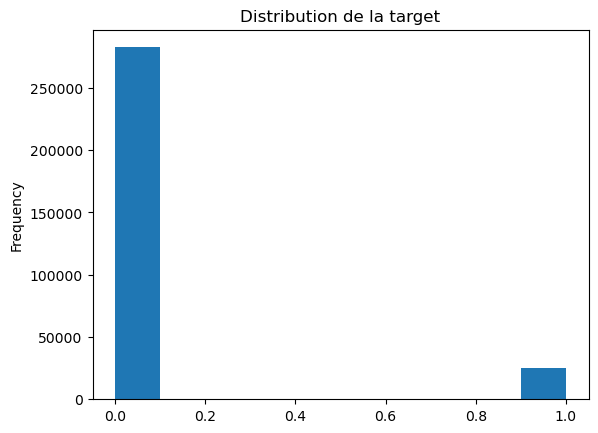

In [7]:
app_train['TARGET'].plot.hist()
plt.title("Distribution de la target")
plt.show()

C'est une version plus visuelle, simple à présenter, de ce déséquilibre.

## 3.2 Valeurs manquantes

In [8]:
mis_val = app_train.isnull().sum()

In [9]:
mis_val_percent = mis_val / len(app_train) * 100

In [10]:
mis_val_percent.sort_values()

SK_ID_CURR                      0.000000
HOUR_APPR_PROCESS_START         0.000000
REG_REGION_NOT_WORK_REGION      0.000000
LIVE_REGION_NOT_WORK_REGION     0.000000
REG_CITY_NOT_LIVE_CITY          0.000000
                                 ...    
NONLIVINGAPARTMENTS_MEDI       69.432963
NONLIVINGAPARTMENTS_MODE       69.432963
COMMONAREA_MODE                69.872297
COMMONAREA_AVG                 69.872297
COMMONAREA_MEDI                69.872297
Length: 122, dtype: float64

Cela nous donne une première idée du nombre de valeurs manquantes. Mais pour l'instant, tout ce qu'on peut en tirer, c'est que certaines colonnes sont pleines, et qu'aucune n'est vide à plus de 70%.

Essayons un meilleur affichage.

In [11]:
def missing_values_table(df):
    """
    Takes a dataframe, and returns :
    - the amount of columns with missing values
    - a table with, for each row, shows how many (flat and percentage) missing values there are
    """
    # Total missing values
    miss_val = df.isnull().sum()
    
    # Same, but percentage wise
    miss_val_percentage = (miss_val / len(df) * 100).round(1)
    
    # Creating table
    miss_val_table = pd.concat([miss_val, miss_val_percentage], axis = 1)
    
    # Renaming columns
    miss_val_table = miss_val_table.rename(columns = {
        0 : 'Missing Values',
        1 : '% of Total Values'
    })
    
    # Sorting by most missing values
    miss_val_table_sorted = miss_val_table.sort_values('Missing Values', ascending = False)
    
    # Printing amount of columns with missing values
    amount_of_columns = miss_val_table[miss_val_table.iloc[:,0] != 0].shape[0]
    print("This dataframe has", df.shape[1], "columns. \n"
         "There are", amount_of_columns, "columns with missing values.")
    
    # Returning the table
    return miss_val_table_sorted
    

In [12]:
missing_values = missing_values_table(app_train)
missing_values.head(20)

This dataframe has 122 columns. 
There are 67 columns with missing values.


,Missing Values,% of Total Values
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_AVG,213514,69.4
NONLIVINGAPARTMENTS_MEDI,213514,69.4
FONDKAPREMONT_MODE,210295,68.4
LIVINGAPARTMENTS_MODE,210199,68.4
LIVINGAPARTMENTS_AVG,210199,68.4
LIVINGAPARTMENTS_MEDI,210199,68.4


Plus tard, lorsqu'on entraînera des modèles, il faudra imputer sur un certain nombre de nos features.

étant donné que toutes les features contiennent au moins 30% de valeurs renseignées, je ne souhaite en supprimer aucune (Du moins, pour l'instant).

De plus, certains modèles sont capables de gérer les valeurs manquantes sans imputation.

## 3.3 Features catégorielles

In [13]:
# Posons la question directement
app_train.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

On a donc 16 "object", représentant les colonnes avec des variables catégorielles. Comptons le nombre de leurs catégories

In [14]:
app_train.select_dtypes("object").apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

Hormis peut-être ORGANIZATION_TYPE (et encore, avec plus de 300 000 lignes, ça peut aller), le nombre de catégories est très raisonnable, et donc ces features seront utilisables. Il faut donc les encoder.

In [15]:
# J'utilise un LabelEncoder, UNIQUEMENT pour les features avec 2 catégories
le = LabelEncoder()
le_count = 0

# Je parcours mes colonnes et je teste si 1. elles sont de type object et 2. elles ont 2 catégories
for col in app_train:
    if app_train[col].dtype == "object":
        if len(list(app_train[col].unique())) <= 2:
            # Dans ce cas, j'utilise le LabelEncoder
            app_train[col] = le.fit_transform(app_train[col])
            
            le_count += 1

print(le_count, "colonnes encodées avec LabelEncoder")

3 colonnes encodées avec LabelEncoder


Bon, j'en comptais 4 sur mes catégories juste au-dessus, mais ce n'est pas très grave. Pour le reste, on utilise un One-Hot encoding

In [16]:
app_train = pd.get_dummies(app_train)

print("Nouvelle taille de app_train :", app_train.shape)

Nouvelle taille de app_train : (307511, 243)


## 3.4 Anomalies

Je serai particulièrement non exhaustif dans cette partie. La recherche d'outliers sur l'intégralité des features me prendrait un temps considérable et, après lecture de plusieurs kernels (comme précédemment mentionné), je vais me contenter d'aller à l'essentiel.

In [17]:
app_train.describe()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes
count,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,...,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000
mean,278180.518577,0.080729,0.095213,0.340108,0.693673,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,...,0.003941,0.030090,0.007466,0.005785,0.005284,0.214757,0.210773,0.017437,0.518446,0.007570
std,102790.175348,0.272419,0.293509,0.473746,0.460968,0.722121,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,...,0.062656,0.170835,0.086085,0.075840,0.072501,0.410654,0.407858,0.130892,0.499660,0.086679
min,100002.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189145.500000,0.000000,0.000000,0.000000,0.000000,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,278202.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,367142.500000,0.000000,0.000000,1.000000,1.000000,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,456255.000000,1.000000,1.000000,1.000000,1.000000,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Le dataframe est trop grand, on va devoir lui préciser ce qu'on veut observer.

Par exemple, on s'intéresse à DAYS_BIRTH. Pour simplifier, je vais diviser par 365 pour l'avoir en années, et par -1 car la donnée renseignée est négative (car la date de naissance est antérieure au prêt).

In [18]:
(app_train["DAYS_BIRTH"] / -365).describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

Pas d'incohérences ici. Tout le monde a bien 18 ans ou plus, et le maximum est cohérent aussi.

Observons le temps d'emploiement.

In [19]:
(app_train["DAYS_EMPLOYED"] / -365).describe()

count    307511.000000
mean       -174.835742
std         387.056895
min       -1000.665753
25%           0.791781
50%           3.323288
75%           7.561644
max          49.073973
Name: DAYS_EMPLOYED, dtype: float64

Là, on a un souci. Non seulement le minimum a travaillé -1000 ans (!!), mais la moyenne est, elle aussi, négative (et pas qu'un peu), indiquant que l'outlier n'est probablement pas seul. Observons autrement.

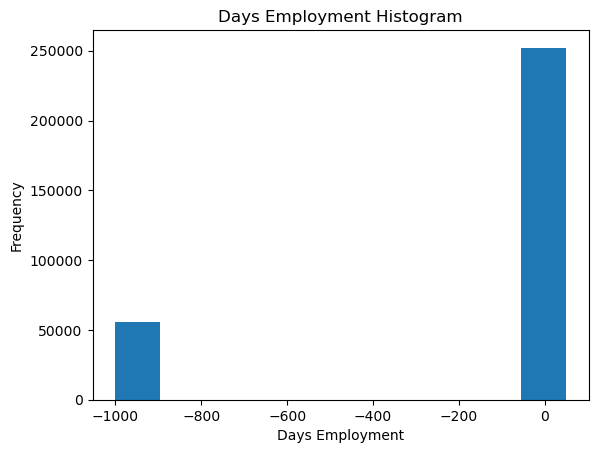

In [20]:
(app_train['DAYS_EMPLOYED'] / -365).plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment')
plt.show()

In [21]:
app_train['DAYS_EMPLOYED'].value_counts()

 365243    55374
-200         156
-224         152
-230         151
-199         151
           ...  
-13961         1
-11827         1
-10176         1
-9459          1
-8694          1
Name: DAYS_EMPLOYED, Length: 12574, dtype: int64

On y voit plus clair.
En fait, il n'y a qu'un seul outlier... reproduit 55374 fois !

Avant de le faire disparaitre, je me demande si ces clients ont quelque chose de particulier. Mettons les en face de la target, et comparons les scores.

In [22]:
anom = app_train[app_train['DAYS_EMPLOYED'] == 365243]
non_anom = app_train[app_train['DAYS_EMPLOYED'] != 365243]
print('Les clients présentant l\'anomalie font défaut sur %0.2f%% des prêts' % (100 * non_anom['TARGET'].mean()))
print("Les clients présentant l'anomalie font défaut sur %0.2f%% des prêts" % (100 * anom['TARGET'].mean()))

Les clients présentant l'anomalie font défaut sur 8.66% des prêts
Les clients présentant l'anomalie font défaut sur 5.40% des prêts


Il semblerait donc que la présence de cette anomalie soit corrélée, d'une manière ou d'une autre, à la target.

Pour conserver cette information, j'ajoute une colonne "Days_Employed_Anom", valant 0 ou 1, pour chaque client.

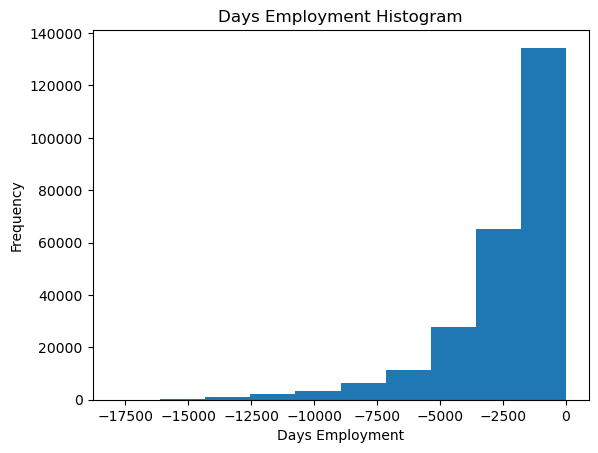

In [23]:
# On créé la nouvelle colonne
app_train['DAYS_EMPLOYED_ANOM'] = app_train["DAYS_EMPLOYED"] == 365243
app_train['DAYS_EMPLOYED_ANOM'] = le.fit_transform(app_train['DAYS_EMPLOYED_ANOM'])

# On supprime l'anomalie
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

app_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram')
plt.xlabel('Days Employment')
plt.show()

Cette distribution semble bien plus raisonnable.

In [24]:
#On vérifie qu'on a bien la colone qu'on souhaitait
app_train['DAYS_EMPLOYED_ANOM']

0         0
1         0
2         0
3         0
4         0
         ..
307506    0
307507    1
307508    0
307509    0
307510    0
Name: DAYS_EMPLOYED_ANOM, Length: 307511, dtype: int64

In [25]:
app_train['DAYS_EMPLOYED_ANOM'].describe()

count    307511.000000
mean          0.180072
std           0.384248
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: DAYS_EMPLOYED_ANOM, dtype: float64

C'est parfait.

## 3.5 Corrélations

Pour commencer, on s'intéresse à la corrélation que chacune de nos features peut avoir avec la target. Cela nous donnera une bonne première idée de quelles sont les features qu'on souhaitera réellement utiliser ensuite, et inversement.

In [26]:
correlations = app_train.corr()['TARGET'].sort_values()
print('Plus fortes corrélations positives:\n', correlations.tail(15))
print('\nPlus fortes corrélations négatives:\n', correlations.head(15))

Plus fortes corrélations positives:
 OCCUPATION_TYPE_Laborers                             0.043019
FLAG_DOCUMENT_3                                      0.044346
REG_CITY_NOT_LIVE_CITY                               0.044395
FLAG_EMP_PHONE                                       0.045982
NAME_EDUCATION_TYPE_Secondary / secondary special    0.049824
REG_CITY_NOT_WORK_CITY                               0.050994
DAYS_ID_PUBLISH                                      0.051457
CODE_GENDER_M                                        0.054713
DAYS_LAST_PHONE_CHANGE                               0.055218
NAME_INCOME_TYPE_Working                             0.057481
REGION_RATING_CLIENT                                 0.058899
REGION_RATING_CLIENT_W_CITY                          0.060893
DAYS_EMPLOYED                                        0.074958
DAYS_BIRTH                                           0.078239
TARGET                                               1.000000
Name: TARGET, dtype: float64

Plu

C'est... très décevant ! 
Parmi nos (environ) 250 features, pas une seule ne dépasse les 0.2 de corrélation avec la target (en valeur absolue).

Si on souhaite faire un "classement", les premières features sont les suivantes :

In [27]:
abs(correlations).sort_values(ascending = False).head(10)

TARGET                                  1.000000
EXT_SOURCE_3                            0.178919
EXT_SOURCE_2                            0.160472
EXT_SOURCE_1                            0.155317
DAYS_BIRTH                              0.078239
DAYS_EMPLOYED                           0.074958
REGION_RATING_CLIENT_W_CITY             0.060893
REGION_RATING_CLIENT                    0.058899
NAME_INCOME_TYPE_Working                0.057481
NAME_EDUCATION_TYPE_Higher education    0.056593
Name: TARGET, dtype: float64

### 3.5.1 Days Birth

Hormis les "Ext_Source", qui sont décrites comme des "sources externes normalisées", et qui sont donc relativement difficiles à interpréter, la variable qui score le "plus haut" (ou disons le moins bas...) est "DAYS_BIRTH".

Observons, comme nous le pouvons, l'influence de l'âge du client sur les défauts de paiement.

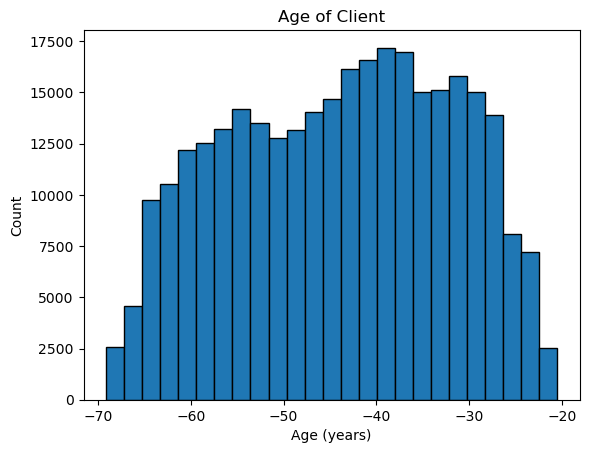

In [28]:
# On commence par afficher la distribution de cette variable
plt.hist(app_train['DAYS_BIRTH'] / 365, edgecolor = 'k', bins = 25)
plt.title('Age of Client')
plt.xlabel('Age (years)')
plt.ylabel('Count')
plt.show()

Elle est relativement uniforme entre 25 et 65 ans. La répartition est bien étalée.

Essayons, à présent, la même visualisation, mais en densité, et avec une courbe pour les bons clients, et une pour les mauvais. (KDE Plot)

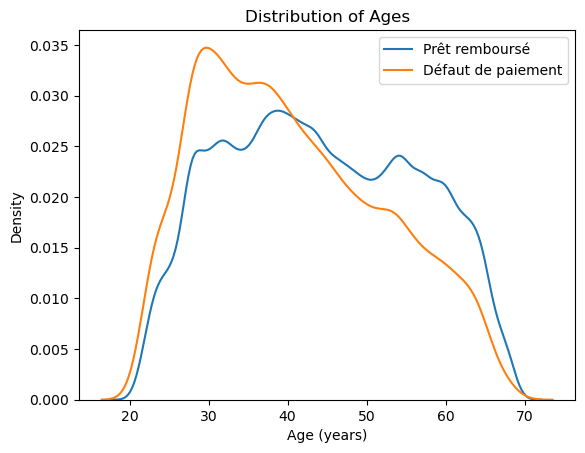

In [29]:
# Pour avoir des âges positifs et non négatifs
app_train['DAYS_BIRTH'] = -app_train['DAYS_BIRTH']

# KDE plot pour les prêts remboursés
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, 'DAYS_BIRTH'] / 365, label = 'Prêt remboursé')

# KDE plot pour les défauts de paiement
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, 'DAYS_BIRTH'] / 365, label = 'Défaut de paiement')

# légendes
plt.xlabel('Age (years)')
plt.ylabel('Density')
plt.title('Distribution of Ages')
plt.legend()
plt.show()

Les courbes sont très proches, avec une légère augmentation des défauts de paiement chez les plus jeunes. Toutefois, c'est trop léger (la corrélation est très faible) pour avoir des certitudes.

Prenons le problème dans l'autre sens : au lieu de partir de la target et observer l'âge, partons de l'âge et observons la target.

Pour obtenir quelque chose de lisible, on va créer des classes d'âges, par exemple avec 5 ans d'amplitude :

In [30]:
# On isole les variables intéressantes
age_data = app_train[['TARGET', 'DAYS_BIRTH']]
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365

# On sépare en classes de 5 ans d'amplitude
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))
age_data.head(10)

C:\Users\Yann\AppData\Local\Temp\ipykernel_8148\3539405979.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365
C:\Users\Yann\AppData\Local\Temp\ipykernel_8148\3539405979.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))


,TARGET,DAYS_BIRTH,YEARS_BIRTH,YEARS_BINNED
0,1,9461,25.920548,"(25.0, 30.0]"
1,0,16765,45.931507,"(45.0, 50.0]"
2,0,19046,52.180822,"(50.0, 55.0]"
3,0,19005,52.068493,"(50.0, 55.0]"
4,0,19932,54.608219,"(50.0, 55.0]"
5,0,16941,46.413699,"(45.0, 50.0]"
6,0,13778,37.747945,"(35.0, 40.0]"
7,0,18850,51.643836,"(50.0, 55.0]"
8,0,20099,55.065753,"(55.0, 60.0]"
9,0,14469,39.641096,"(35.0, 40.0]"


In [31]:
# On regroupe les classes, en moyennant sur la target
age_groups  = age_data.groupby('YEARS_BINNED').mean()
age_groups

,TARGET,DAYS_BIRTH,YEARS_BIRTH
YEARS_BINNED,,,
"(20.0, 25.0]",0.123036,8532.795625,23.377522
"(25.0, 30.0]",0.111436,10155.219250,27.822518
"(30.0, 35.0]",0.102814,11854.848377,32.479037
"(35.0, 40.0]",0.089414,13707.908253,37.555913
"(40.0, 45.0]",0.078491,15497.661233,42.459346
"(45.0, 50.0]",0.074171,17323.900441,47.462741
"(50.0, 55.0]",0.066968,19196.494791,52.593136
"(55.0, 60.0]",0.055314,20984.262742,57.491131
"(60.0, 65.0]",0.052737,22780.547460,62.412459


On peut lire les conclusions dès maintenant, mais commençons par un visuel plus parlant.

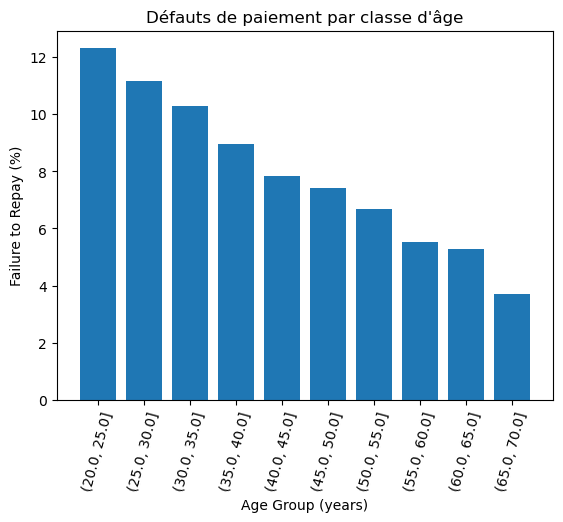

In [32]:
# Avec un barplot
plt.bar(age_groups.index.astype(str), 100 * age_groups['TARGET'])

plt.xticks(rotation = 75)
plt.xlabel('Age Group (years)')
plt.ylabel('Failure to Repay (%)')
plt.title('Défauts de paiement par classe d\'âge')
plt.show()

La tendance est très nette. Plus le client est jeune, plus il a de risques de nous faire défaut. Cette feature sera donc très probablement importante pour la suite.

### 3.5.2 Les "EXT_SOURCE"

Les 3 variables les plus corrélées à la target (et de très loin !) sont aussi les 3 variables les moins interprétables de tout mon jeu de données. Leur calcul n'est pas expliqué par ce qui m'a été fourni.

Commençons par quelques observations

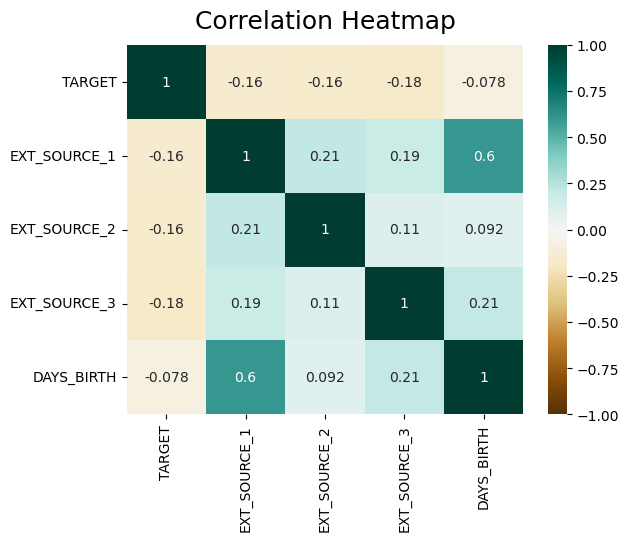

In [33]:
# On les sort du dataframe, avec la target et days_birth
ext_data = app_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
ext_data_corrs = ext_data.corr()
heatmap = sns.heatmap(ext_data_corrs, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12)
plt.show()

- On le savait déjà, mais les 3 EXT_SOURCE sont corrélées négativement à la target. Cela implique que plus les scores du client sont hauts vis à vis de ces variables, plus il sera à même de nous rembourser dans les temps.

- EXT_SOURCE_1 semble avoir l'âge du client intégré dans son mode de calcul, car la corrélation entre ces variables est forte.

On peut aussi, comme pour l'âge auparavant, regarder des densités en fonction de la target pour les 3 EXT_SOURCE (je reprends intégralement le code du kernel dont je m'inspire):

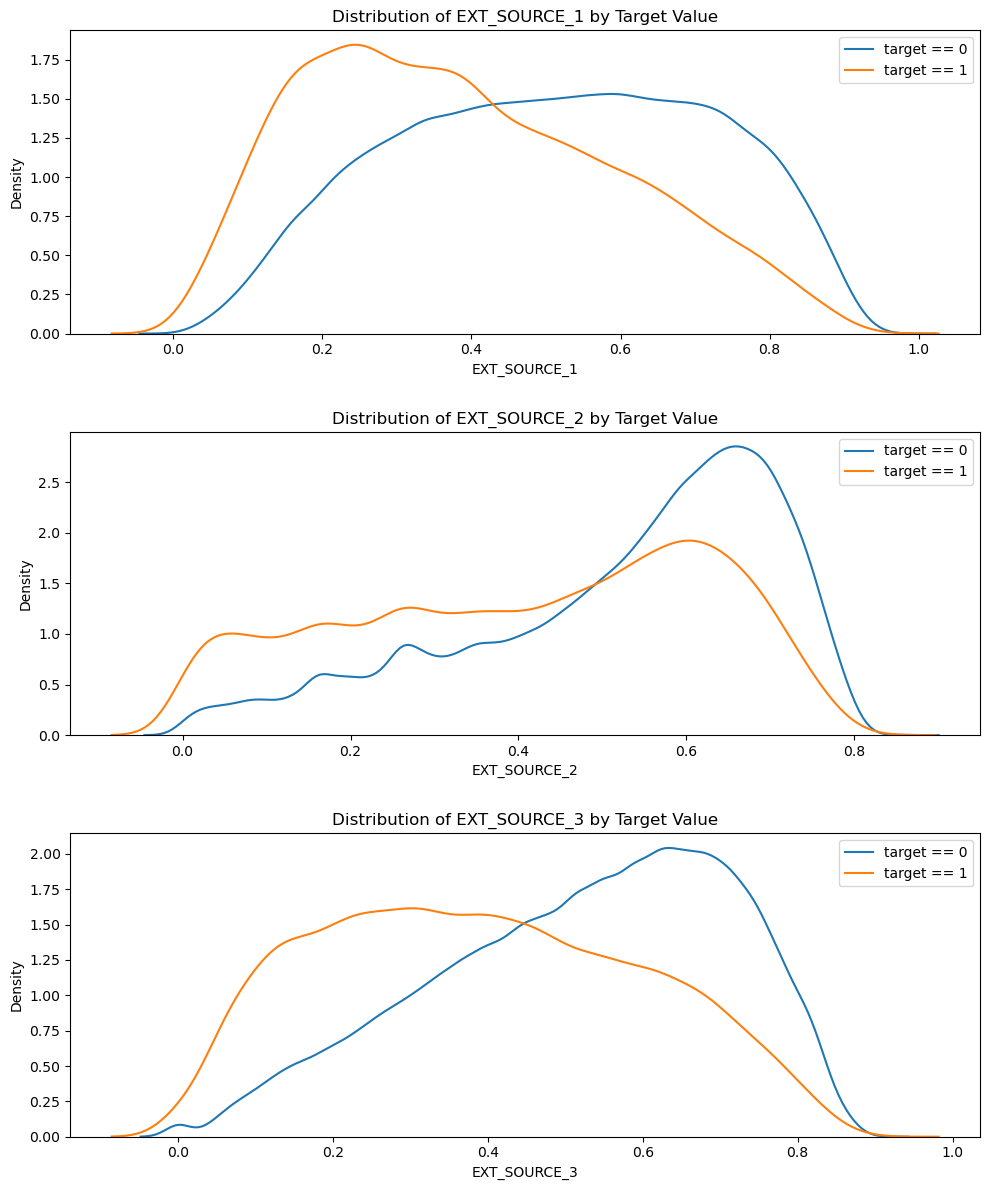

In [34]:
plt.figure(figsize = (10, 12))

for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):
    
    # create a new subplot for each source
    plt.subplot(3, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, source], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, source], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel('%s' % source)
    plt.ylabel('Density')
    plt.legend()
    
plt.tight_layout(h_pad = 2.5)

C'est pour EXT_SOURCE_3 qu'on remarque la plus grande disparité entre les deux courbes. Et globalement, ces 3 variables seront probablement très importantes (même si ça ne me plaît guère, étant donné notre objectif de transparence vis à vis du client par la suite...)

# 4. Autres CSV et Feature Engineering

## 4.0 Connaissance métier

Pour le feature engineering, on a plusieurs solutions. L'une d'entre elles est de créer des features dont on sait qu'elles vont correspondre à des problématiques réelles du métier.

Je ne suis pas expert dans les banques, en revanche, j'ai eu plusieurs idées. Je les écris ici, et nous y reviendrons dans un second temps, car je vais d'abord procéder autrement, et peut-être aurai-je déjà accidentellement créé certaines des features que je souhaite rajouter.

Voici la liste :
- La durée du crédit (en mois ou en années)
- Le ratio "Revenu du client" / "Mensualités du prêt"
- (Facultatif) Le client a-t-il 3x le montant des mensualités en revenus (Oui/Non)
- Le ratio "Jours travaillés"/"Jours vécus", en partant des 18 ans
- Le nombre de prêts précédemment contractés *
- La date du dernier prêt contracté *
- Le client a-t-il déjà un prêt en cours ? (Oui/Non) *
- Le taux d'intérêt annuel
- Le client a-t-il déjà été en défaut de paiement auparavant ? (Oui/Non)

## 4.1 Bureau et Bureau_balance

On commence par ces deux datasets, rappelons que :

- "bureau" contient des informations sur tous les prêts précédemment contractés au cours de la vie de notre client (dont Home Credit a connaissance). Une ligne correspond à un prêt.

- "bureau_balance", lui, contient pour chacun de ces prêts une ligne par mois, contenant des informations.

### 4.1.1 Import des données

In [35]:
# On les récupère
bureau = pd.read_csv('../Données/bureau.csv')
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [36]:
bureau_balance = pd.read_csv('../Données/bureau_balance.csv')
bureau_balance.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


Je vais, pour l'instant, me concentrer sur "bureau".

La première remarque, c'est que sur le petit head() effectué ci-dessus, on se rend compte assez rapidement qu'on va facilement trouver des clients avec plusieurs prêts. En effet, "SK_ID_CURR" est le même pour les 5 premières lignes.

Je vais commencer par vérifier la taille de "bureau", et aussi que le nombre d'identifiants uniques est le même que pour "app_train".

In [37]:
bureau.shape

(1716428, 17)

In [38]:
#C'est bien plus grand que app_train.
bureau["SK_ID_CURR"].unique().shape

(305811,)

Il nous manque 1700 individus. Il faudra tenir compte de cela lors de la fusion. Et entre bureau_balance et bureau ?

In [39]:
bureau_balance["SK_ID_BUREAU"].unique().shape

(817395,)

In [40]:
bureau_balance.shape

(27299925, 3)

Là aussi, il manquera du monde pour la fusion... On verra cela dans un second temps.

### 4.1.2 Traitement d'un exemple.

Dans cette sous-partie, je vais considérer un exemple, facile à fabriquer, et qui faisait partie de ma "liste" (cf partie 4.0) :

Le nombre de crédits contractés auparavant (à notre connaissance). Il suffit d'un groupby.

In [41]:
previous_loans = bureau.groupby("SK_ID_CURR", as_index = False)["SK_ID_BUREAU"].count()

# Je renomme les colonnes
previous_loans = previous_loans.rename(columns = {
    'SK_ID_BUREAU' : 'previous_loan_counts'
})
previous_loans.head()

,SK_ID_CURR,previous_loan_counts
0,100001,7
1,100002,8
2,100003,4
3,100004,2
4,100005,3


A présent, je souhaite l'ajouter à mon dataframe principal :

In [42]:
# Comme c'est juste un exemple, je ne veux pas affecter mon app_train actuel
train = pd.read_csv('../Données/application_train.csv')
train = train.merge(previous_loans, on = 'SK_ID_CURR', how = 'left')

# Puisqu'il manque des données, je dois remplir les valeurs manquantes
train['previous_loan_counts'] = train['previous_loan_counts'].fillna(0)

Enfin, je vais évaluer l'impact potentiel de cette nouvelle feature, en calculant le coefficient de corrélation avec ma target, et en traçant le KDE plot (comme précédemment avec DAYS_BIRTH ou les EXT_SOURCES).

Pour cela, j'écris une fonction (encore une fois fortement reprise d'un kernel Kaggle).

In [43]:
def kde_target(var_name, df):
    """
    - Calculates the correlation coefficient between the new variable and the target
    - Plots the distribution of the new variable for target == 0 and target == 1
    - Calculates median for repaid vs not repaid
    """
    # On commence par le coefficient de corrélation
    corr = df['TARGET'].corr(df[var_name])
    print('Le coefficient de corrélation entre la target et cette variable est', corr)
    
    # On calcule les médianes 
    med_repaid = round(df.loc[df['TARGET'] == 0, var_name].median(),3)
    med_not_repaid = round(df.loc[df['TARGET'] == 1, var_name].median(),3)
    print("Valeur médiane pour les prêts remboursés :", med_repaid)
    print("Valeur médiane pour les prêts non remboursés", med_not_repaid)
    
    # On trace le KDE plot
    sns.kdeplot(df.loc[df['TARGET'] == 0, var_name], label = 'Remboursé')
    sns.kdeplot(df.loc[df['TARGET'] == 1, var_name], label = 'Non Remboursé')
    
    # Légendes
    plt.xlabel(var_name)
    plt.ylabel('Density')
    plt.legend()
    plt.title("Distribution de %s" % var_name)
    plt.show()

Le coefficient de corrélation entre la target et cette variable est -0.1789186976283708
Valeur médiane pour les prêts remboursés : 0.546
Valeur médiane pour les prêts non remboursés 0.379


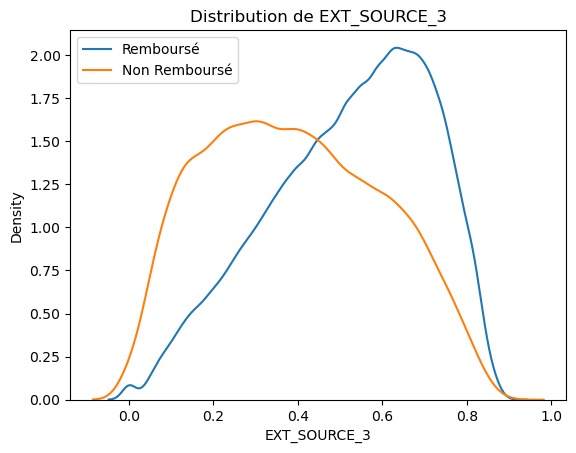

In [44]:
# Test de ma fonction sur une variable déjà connue, pour vérifier que tout fonctionne
kde_target('EXT_SOURCE_3', train)

Le coefficient de corrélation entre la target et cette variable est -0.010019715670684074
Valeur médiane pour les prêts remboursés : 4.0
Valeur médiane pour les prêts non remboursés 3.0


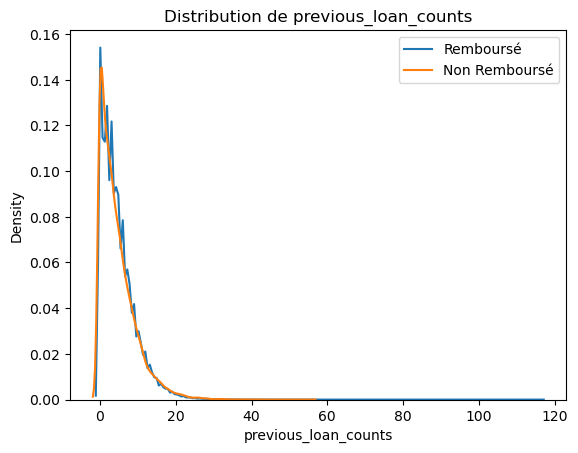

In [45]:
# Tout fonctionne, essayons avec loan_counts
kde_target('previous_loan_counts', train)

Conclusion ? Cette variable semble assez peu importante. Les courbes sont quasi confondues, et le coefficient de corrélation est extrêmement faible.

### 4.1.3 Agrégation des features numériques

Dans nos dataframes, on a, de nouveau, des features numériques et des catégorielles. Dans un premier temps, je m'intéresse uniquement aux numériques.

Contrairement à ce que j'ai fait dans l'exemple ci-dessus, on n'est pas obligés de ne garder qu'une colonne lorsqu'on "groupby". Je vais donc agréger en conservant le nombre d'occurences, la moyenne, le minimum, le maximum, et la somme.

In [46]:
bureau_agg = bureau.drop(columns = ['SK_ID_BUREAU']).groupby(
    'SK_ID_CURR', as_index = False).agg(
    ['count', 'mean', 'max', 'min', 'sum']).reset_index()
bureau_agg.head()

C:\Users\Yann\AppData\Local\Temp\ipykernel_8148\298491781.py:1: FutureWarning: ['CREDIT_ACTIVE', 'CREDIT_CURRENCY', 'CREDIT_TYPE'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  bureau_agg = bureau.drop(columns = ['SK_ID_BUREAU']).groupby(


SK_ID_CURR DAYS_CREDIT                               CREDIT_DAY_OVERDUE  \
                   count         mean  max   min   sum              count   
0     100001           7  -735.000000  -49 -1572 -5145                  7   
1     100002           8  -874.000000 -103 -1437 -6992                  8   
2     100003           4 -1400.750000 -606 -2586 -5603                  4   
3     100004           2  -867.000000 -408 -1326 -1734                  2   
4     100005           3  -190.666667  -62  -373  -572                  3   

                ... DAYS_CREDIT_UPDATE                               \
  mean max min  ...              count        mean  max   min   sum   
0  0.0   0   0  ...                  7  -93.142857   -6  -155  -652   
1  0.0   0   0  ...                  8 -499.875000   -7 -1185 -3999   
2  0.0   0   0  ...                  4 -816.000000  -43 -2131 -3264   
3  0.0   0   0  ...                  2 -532.000000 -382  -682 -1064   
4  0.0   0   0  ...                  3  -54.333333  -11  -121  -163   

  AMT_ANNUITY                                      
        count         mean      max  min      sum  
0           7  3545.357143  10822.5  0.0  24817.5  
1           7     0.000000      0.0  0.0      0.0  
2           0          NaN      NaN  NaN      0.0  
3           0          NaN      NaN  NaN      0.0  
4           3  1420.500000   4261.5  0.0   4261.5  

[5 rows x 61 columns]

On passe de 17 à 61 colonnes, on a donc rajouté pas mal de features. Je ne souhaite pas travailler plus en profondeur que cela, faute de temps.

Je n'aime pas le double index de mes colonnes, je les renomme.

In [47]:
# Initialisation de la liste des colonnes par la seule colonne non "splitée"
cols = ["SK_ID_CURR"]

# Pour chaque colonne au niveau 1, sauf SK_ID_CURR, je créé un novueau nom
for var in bureau_agg.columns.levels[0]:
    if var != "SK_ID_CURR":
        for stat in bureau_agg.columns.levels[1][:-1]:
            cols.append("bureau_%s_%s" %(var, stat))
            
# On modifie les colonnes de bureau_agg
bureau_agg.columns = cols
bureau_agg.head()

,SK_ID_CURR,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,...,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
0,100001,7,-735.000000,-49,-1572,-5145,7,0.0,0,0,...,7,-93.142857,-6,-155,-652,7,3545.357143,10822.5,0.0,24817.5
1,100002,8,-874.000000,-103,-1437,-6992,8,0.0,0,0,...,8,-499.875000,-7,-1185,-3999,7,0.000000,0.0,0.0,0.0
2,100003,4,-1400.750000,-606,-2586,-5603,4,0.0,0,0,...,4,-816.000000,-43,-2131,-3264,0,NaN,NaN,NaN,0.0
3,100004,2,-867.000000,-408,-1326,-1734,2,0.0,0,0,...,2,-532.000000,-382,-682,-1064,0,NaN,NaN,NaN,0.0
4,100005,3,-190.666667,-62,-373,-572,3,0.0,0,0,...,3,-54.333333,-11,-121,-163,3,1420.500000,4261.5,0.0,4261.5


Voilà qui sera plus simple à utiliser par la suite.
Toutefois, je dois tâcher de ne pas perdre la signification de mes colonnes, au risque de perdre en interprétabilité (ce qu'on ne veut surtout pas dans ce projet).

Ensuite, puisque je ne souhaite pas en faire plus, je fusionne, simplement.

In [48]:
app_train = app_train.merge(bureau_agg, on = "SK_ID_CURR", how = "left")
# Cette fois, je laisse les NaN en place. En effet, je n'ai pas de moyen fiable d'imputer
app_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
0,100002,1,0,0,1,0,202500.0,406597.5,24700.5,351000.0,...,8.0,-499.875,-7.0,-1185.0,-3999.0,7.0,0.0,0.0,0.0,0.0
1,100003,0,0,0,0,0,270000.0,1293502.5,35698.5,1129500.0,...,4.0,-816.000,-43.0,-2131.0,-3264.0,0.0,NaN,NaN,NaN,0.0
2,100004,0,1,1,1,0,67500.0,135000.0,6750.0,135000.0,...,2.0,-532.000,-382.0,-682.0,-1064.0,0.0,NaN,NaN,NaN,0.0
3,100006,0,0,0,1,0,135000.0,312682.5,29686.5,297000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,0,0,1,0,121500.0,513000.0,21865.5,513000.0,...,1.0,-783.000,-783.0,-783.0,-783.0,0.0,NaN,NaN,NaN,0.0


Testons si, parmi nos nouvelles variables, certaines sont meilleures que celles de notre dataframe original.

In [49]:
# C'est le même principe que plus haut dans ce notebook
correlations = app_train.corr()['TARGET'].sort_values()
abs(correlations).sort_values(ascending = False).head(20)

TARGET                                  1.000000
EXT_SOURCE_3                            0.178919
EXT_SOURCE_2                            0.160472
EXT_SOURCE_1                            0.155317
bureau_DAYS_CREDIT_mean                 0.089729
DAYS_BIRTH                              0.078239
bureau_DAYS_CREDIT_min                  0.075248
DAYS_EMPLOYED                           0.074958
bureau_DAYS_CREDIT_UPDATE_mean          0.068927
REGION_RATING_CLIENT_W_CITY             0.060893
REGION_RATING_CLIENT                    0.058899
NAME_INCOME_TYPE_Working                0.057481
NAME_EDUCATION_TYPE_Higher education    0.056593
bureau_DAYS_ENDDATE_FACT_min            0.055887
DAYS_LAST_PHONE_CHANGE                  0.055218
CODE_GENDER_M                           0.054713
CODE_GENDER_F                           0.054704
bureau_DAYS_CREDIT_ENDDATE_sum          0.053735
bureau_DAYS_ENDDATE_FACT_mean           0.053200
DAYS_ID_PUBLISH                         0.051457
Name: TARGET, dtype:

Aucune feature ne s'approche vraiment du niveau de corrélation des "EXT_SOURCE", ce qui est bien dommage, mais à titre personnel, je me réjouis de voir dans le groupe de tête "bureau_DAYS_CREDIT_min", qui correspond en fait à la date du dernier prêt contracté connu, et qui était l'un des éléments de ma liste (en 4.0), que je n'aurai donc pas à ajouter manuellement par ailleurs.

Testons notre fonction "test d'une variable" sur celle-ci.

Le coefficient de corrélation entre la target et cette variable est 0.07524825103010374
Valeur médiane pour les prêts remboursés : -1861.0
Valeur médiane pour les prêts non remboursés -1469.0


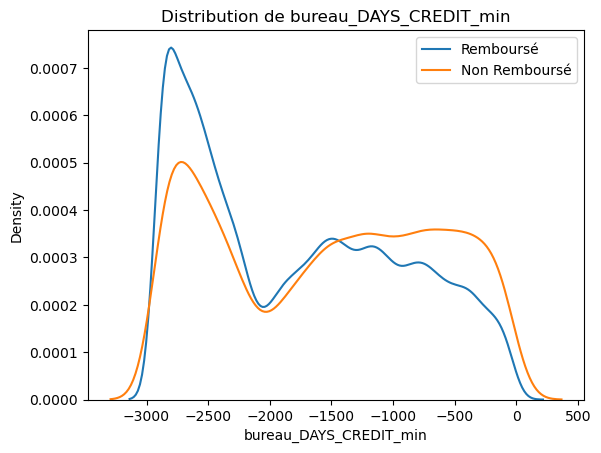

In [50]:
kde_target("bureau_DAYS_CREDIT_min", app_train)

Les tendances des deux courbes sont tout de même similaires. On peut constater que les personnes ayant contracté leur dernier prêt plus récemment ont très légèrement tendance à faire défaut plus souvent que les autres.

A nouveau, la tendance est faible et c'est normal au vu du coefficient de corrélation, très faible lui aussi. Il ne faut également pas oublier que du simple bruit peut aussi expliquer ce qu'on voit sur ce graphique.

Encore une fois, la fonction suivante est en grand majorité reprise de Kaggle, et me permet de réitérer sur les prochains dataframes.

In [51]:
# Pour pouvoir refaire ça plus rapidement sur les autres datasets, j'écris une fonction

def agg_numeric_features(df, group_var, df_name):
    """
    Aggregates the numeric values in a dataframe.
    This can be used to create features for each instance of the grouping variable.
    
    Parameters
    ------
        df (dataframe):
            the dataframe to calculate the statistics on
        group_var (string):
            the variable by which to group df
        df_name (string):
            the name you want at the start of the new variables
            
    Return
    -------
        agg(dataframe):
            a dataframe with the statistics aggregated for all columns.
            Each instance of the grouping variable will have count, mean, min, max and sum calculated.
            The columns are also renamed to keep track of the features created.
    """
    
    # Removing all "ID" variables other than the grouping variable
    for col in df:
        if col != group_var and 'SK_ID' in col:
            df = df.drop(columns = col)
            
    # Restricting to only numerical variables
    group_ids = df[group_var]
    numeric_df = df.select_dtypes('number')
    numeric_df[group_var] = group_ids
    
    # Group by our group_var and calculate the mean, min, max, count and sum
    agg = numeric_df.groupby(group_var).agg(['count','mean','max','min','sum']).reset_index()
    
    # Now we only need to rename our columns
    columns = [group_var]
    for var in agg.columns.levels[0]:
        if var != group_var:
            for stat in agg.columns.levels[1][:-1]:
                columns.append('%s_%s_%s' % (df_name, var, stat))
    
    agg.columns = columns
    return agg
        

In [52]:
#Testons la fonction sur notre exemple et comparons
bureau_agg_with_function = agg_numeric_features(bureau, group_var = 'SK_ID_CURR', df_name = 'bureau')
bureau_agg_with_function.head()

,SK_ID_CURR,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,...,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
0,100001,7,-735.000000,-49,-1572,-5145,7,0.0,0,0,...,7,-93.142857,-6,-155,-652,7,3545.357143,10822.5,0.0,24817.5
1,100002,8,-874.000000,-103,-1437,-6992,8,0.0,0,0,...,8,-499.875000,-7,-1185,-3999,7,0.000000,0.0,0.0,0.0
2,100003,4,-1400.750000,-606,-2586,-5603,4,0.0,0,0,...,4,-816.000000,-43,-2131,-3264,0,NaN,NaN,NaN,0.0
3,100004,2,-867.000000,-408,-1326,-1734,2,0.0,0,0,...,2,-532.000000,-382,-682,-1064,0,NaN,NaN,NaN,0.0
4,100005,3,-190.666667,-62,-373,-572,3,0.0,0,0,...,3,-54.333333,-11,-121,-163,3,1420.500000,4261.5,0.0,4261.5


In [53]:
bureau_agg.head()

,SK_ID_CURR,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,...,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
0,100001,7,-735.000000,-49,-1572,-5145,7,0.0,0,0,...,7,-93.142857,-6,-155,-652,7,3545.357143,10822.5,0.0,24817.5
1,100002,8,-874.000000,-103,-1437,-6992,8,0.0,0,0,...,8,-499.875000,-7,-1185,-3999,7,0.000000,0.0,0.0,0.0
2,100003,4,-1400.750000,-606,-2586,-5603,4,0.0,0,0,...,4,-816.000000,-43,-2131,-3264,0,NaN,NaN,NaN,0.0
3,100004,2,-867.000000,-408,-1326,-1734,2,0.0,0,0,...,2,-532.000000,-382,-682,-1064,0,NaN,NaN,NaN,0.0
4,100005,3,-190.666667,-62,-373,-572,3,0.0,0,0,...,3,-54.333333,-11,-121,-163,3,1420.500000,4261.5,0.0,4261.5


Tout semble parfaitement similaire. On a donc une fonction qui nous permet bien de reproduire ces étapes !

Il y a aussi quelque chose que j'ai déjà fait 2 fois, et que je vais reproduire encore, c'est la comparaison de mes features en terme de corrélation avec ma target. Je vais aussi écrire une fonction pour cela.

In [54]:
def most_correlated_features(df, amount):
    """
    Calculates the correlation coefficients between all the features and TARGET.
    
    Parameters
    ------
        df(dataframe) : the dataframe to be used
        amount(int)   : the amount of variables you want to see
    
    Return
    ------
        the list of the top "amount" best variables correlation-wise, with the associated
        correlation coefficients.
    """
    correlations = df.corr()['TARGET'].sort_values()
    return abs(correlations).sort_values(ascending = False).head(amount)


In [55]:
# Je teste aussi
most_correlated_features(app_train, 20)

TARGET                                  1.000000
EXT_SOURCE_3                            0.178919
EXT_SOURCE_2                            0.160472
EXT_SOURCE_1                            0.155317
bureau_DAYS_CREDIT_mean                 0.089729
DAYS_BIRTH                              0.078239
bureau_DAYS_CREDIT_min                  0.075248
DAYS_EMPLOYED                           0.074958
bureau_DAYS_CREDIT_UPDATE_mean          0.068927
REGION_RATING_CLIENT_W_CITY             0.060893
REGION_RATING_CLIENT                    0.058899
NAME_INCOME_TYPE_Working                0.057481
NAME_EDUCATION_TYPE_Higher education    0.056593
bureau_DAYS_ENDDATE_FACT_min            0.055887
DAYS_LAST_PHONE_CHANGE                  0.055218
CODE_GENDER_M                           0.054713
CODE_GENDER_F                           0.054704
bureau_DAYS_CREDIT_ENDDATE_sum          0.053735
bureau_DAYS_ENDDATE_FACT_mean           0.053200
DAYS_ID_PUBLISH                         0.051457
Name: TARGET, dtype:

ça aussi, c'est validé !

### 4.1.4 Agrégation des variables catégorielles

In [56]:
bureau_categ = bureau.select_dtypes('object')
bureau_categ["SK_ID_CURR"] = bureau["SK_ID_CURR"]
bureau_categ.head(10)

,CREDIT_ACTIVE,CREDIT_CURRENCY,CREDIT_TYPE,SK_ID_CURR
0,Closed,currency 1,Consumer credit,215354
1,Active,currency 1,Credit card,215354
2,Active,currency 1,Consumer credit,215354
3,Active,currency 1,Credit card,215354
4,Active,currency 1,Consumer credit,215354
5,Active,currency 1,Credit card,215354
6,Active,currency 1,Consumer credit,215354
7,Closed,currency 1,Consumer credit,162297
8,Closed,currency 1,Consumer credit,162297
9,Active,currency 1,Credit card,162297


Pour les variables catégorielles, c'est un peu différent. Par exemple, il n'y a pas de "minimum", à proprement parler.

En revanche, on peut :
1. Encoder (One-Hot) les variables.
2. Compter combien de fois chaque catégorie apparait pour chaque client
(Par exemple, pour l'ID 215354 ci-dessus, 6 crédits sont "Active", et un seul "Closed)
3. Calculer les fréquences associées (ce qui revient à moyenner avec l'encodage)
(Même exemple, la fréquence de "Active" sera 6/7)

In [57]:
categorical = pd.get_dummies(bureau.select_dtypes('object'))
categorical["SK_ID_CURR"] = bureau["SK_ID_CURR"]
categorical.head(10)

,CREDIT_ACTIVE_Active,CREDIT_ACTIVE_Bad debt,CREDIT_ACTIVE_Closed,CREDIT_ACTIVE_Sold,CREDIT_CURRENCY_currency 1,CREDIT_CURRENCY_currency 2,CREDIT_CURRENCY_currency 3,CREDIT_CURRENCY_currency 4,CREDIT_TYPE_Another type of loan,CREDIT_TYPE_Car loan,...,CREDIT_TYPE_Loan for business development,CREDIT_TYPE_Loan for purchase of shares (margin lending),CREDIT_TYPE_Loan for the purchase of equipment,CREDIT_TYPE_Loan for working capital replenishment,CREDIT_TYPE_Microloan,CREDIT_TYPE_Mobile operator loan,CREDIT_TYPE_Mortgage,CREDIT_TYPE_Real estate loan,CREDIT_TYPE_Unknown type of loan,SK_ID_CURR
0,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,215354
1,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,215354
2,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,215354
3,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,215354
4,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,215354
5,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,215354
6,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,215354
7,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,162297
8,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,162297
9,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,162297


In [58]:
# Comme d'habitude, l'encodage augmente fortement le nombre de variables
categorical_grouped = categorical.groupby('SK_ID_CURR').agg(['sum','mean']).reset_index()
categorical_grouped.head()

SK_ID_CURR CREDIT_ACTIVE_Active           CREDIT_ACTIVE_Bad debt       \
                              sum      mean                    sum mean   
0     100001                    3  0.428571                      0  0.0   
1     100002                    2  0.250000                      0  0.0   
2     100003                    1  0.250000                      0  0.0   
3     100004                    0  0.000000                      0  0.0   
4     100005                    2  0.666667                      0  0.0   

  CREDIT_ACTIVE_Closed           CREDIT_ACTIVE_Sold       \
                   sum      mean                sum mean   
0                    4  0.571429                  0  0.0   
1                    6  0.750000                  0  0.0   
2                    3  0.750000                  0  0.0   
3                    2  1.000000                  0  0.0   
4                    1  0.333333                  0  0.0   

  CREDIT_CURRENCY_currency 1  ... CREDIT_TYPE_Microloan       \
                         sum  ...                   sum mean   
0                          7  ...                     0  0.0   
1                          8  ...                     0  0.0   
2                          4  ...                     0  0.0   
3                          2  ...                     0  0.0   
4                          3  ...                     0  0.0   

  CREDIT_TYPE_Mobile operator loan      CREDIT_TYPE_Mortgage       \
                               sum mean                  sum mean   
0                                0  0.0                    0  0.0   
1                                0  0.0                    0  0.0   
2                                0  0.0                    0  0.0   
3                                0  0.0                    0  0.0   
4                                0  0.0                    0  0.0   

  CREDIT_TYPE_Real estate loan      CREDIT_TYPE_Unknown type of loan       
                           sum mean                              sum mean  
0                            0  0.0                                0  0.0  
1                            0  0.0                                0  0.0  
2                            0  0.0                                0  0.0  
3                            0  0.0                                0  0.0  
4                            0  0.0                                0  0.0  

[5 rows x 47 columns]

On a le même problème que pour les variables numériques : un double index des colonnes.
On procède de la même manière pour le régler.

In [59]:
# Vous connaissez la chanson maintenant.
columns = ["SK_ID_CURR"]

for var in categorical_grouped.columns.levels[0]:
    if var != "SK_ID_CURR":
        for stat in ['count','freq']:
            columns.append('%s_%s' % (var,stat))
            
categorical_grouped.columns = columns

categorical_grouped.head()

,SK_ID_CURR,CREDIT_ACTIVE_Active_count,CREDIT_ACTIVE_Active_freq,CREDIT_ACTIVE_Bad debt_count,CREDIT_ACTIVE_Bad debt_freq,CREDIT_ACTIVE_Closed_count,CREDIT_ACTIVE_Closed_freq,CREDIT_ACTIVE_Sold_count,CREDIT_ACTIVE_Sold_freq,CREDIT_CURRENCY_currency 1_count,...,CREDIT_TYPE_Microloan_count,CREDIT_TYPE_Microloan_freq,CREDIT_TYPE_Mobile operator loan_count,CREDIT_TYPE_Mobile operator loan_freq,CREDIT_TYPE_Mortgage_count,CREDIT_TYPE_Mortgage_freq,CREDIT_TYPE_Real estate loan_count,CREDIT_TYPE_Real estate loan_freq,CREDIT_TYPE_Unknown type of loan_count,CREDIT_TYPE_Unknown type of loan_freq
0,100001,3,0.428571,0,0.0,4,0.571429,0,0.0,7,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
1,100002,2,0.250000,0,0.0,6,0.750000,0,0.0,8,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
2,100003,1,0.250000,0,0.0,3,0.750000,0,0.0,4,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
3,100004,0,0.000000,0,0.0,2,1.000000,0,0.0,2,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
4,100005,2,0.666667,0,0.0,1,0.333333,0,0.0,3,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0


Et voilà. On n'a plus qu'à fusionner ce dataframe avec notre dataframe principal.

Pour faciliter le futur, réécrivons ceci en une fonction.

In [60]:
def count_categorical(df, group_var, df_name):
    """
    Computes counts and frequencies for each observation of 'group_var' of each unique category
    in every categorical variable of 'df'
    
    Parameters
    -------
    df : dataframe
        the dataframe to calculate the value counts for
        
    group_var : string
        the variable to group the dataframe on
        
    df_name : string
        variable added to the front of column names to keep track of columns
        
    Return
    ------
    categorical_grouped : dataframe
        A dataframe with counts and frequencies for each unique category in every categorical variable.
        Has one row for each unique value of 'group_var'
    """
    # Getting only categorical columns
    categorical = pd.get_dummies(df.select_dtypes('object'))
    
    # Getting group_var back because it's not categorical
    categorical[group_var] = df[group_var]
    
    # Grouping on group_var
    categorical_grouped = categorical.groupby(group_var).agg(['sum','mean']).reset_index()
    
    # As usual now, renaming the columns
    columns = [group_var]

    for var in categorical_grouped.columns.levels[0]:
        if var != group_var:
            for stat in ['count','freq']:
                columns.append('%s_%s_%s' % (df_name,var,stat))
            
    categorical_grouped.columns = columns

    return categorical_grouped
    

In [61]:
# Vérification habituelle
bureau_counts = count_categorical(bureau, group_var = 'SK_ID_CURR', df_name = 'bureau')
bureau_counts.head()

,SK_ID_CURR,bureau_CREDIT_ACTIVE_Active_count,bureau_CREDIT_ACTIVE_Active_freq,bureau_CREDIT_ACTIVE_Bad debt_count,bureau_CREDIT_ACTIVE_Bad debt_freq,bureau_CREDIT_ACTIVE_Closed_count,bureau_CREDIT_ACTIVE_Closed_freq,bureau_CREDIT_ACTIVE_Sold_count,bureau_CREDIT_ACTIVE_Sold_freq,bureau_CREDIT_CURRENCY_currency 1_count,...,bureau_CREDIT_TYPE_Microloan_count,bureau_CREDIT_TYPE_Microloan_freq,bureau_CREDIT_TYPE_Mobile operator loan_count,bureau_CREDIT_TYPE_Mobile operator loan_freq,bureau_CREDIT_TYPE_Mortgage_count,bureau_CREDIT_TYPE_Mortgage_freq,bureau_CREDIT_TYPE_Real estate loan_count,bureau_CREDIT_TYPE_Real estate loan_freq,bureau_CREDIT_TYPE_Unknown type of loan_count,bureau_CREDIT_TYPE_Unknown type of loan_freq
0,100001,3,0.428571,0,0.0,4,0.571429,0,0.0,7,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
1,100002,2,0.250000,0,0.0,6,0.750000,0,0.0,8,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
2,100003,1,0.250000,0,0.0,3,0.750000,0,0.0,4,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
3,100004,0,0.000000,0,0.0,2,1.000000,0,0.0,2,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
4,100005,2,0.666667,0,0.0,1,0.333333,0,0.0,3,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0


### 4.1.5 Fusion effective

A présent, j'ai toutes les fonctions qu'il me faut.

Je vais, dans un premier temps, fusionner bureau_balance sur bureau avec SK_BUREAU_ID, puis ensuite fusionner sur app_train avec SK_ID_CURR.

Le seul inconvénient, c'est que les variables venant de bureau_balance commenceront par "bureau_bureau_balance" au lieu de juste "bureau_balance".

Toutefois, si jamais on doit réellement les utiliser pour une interprétation plus tars, cela n'est pas gênant, donc j'accepte de le laisser ainsi.

Afin de pouvoir refaire la même opération sur app_test plus tard, je créé une fonction.

In [62]:
def merge_bureaus (df):
    """
    Just a practical function to merge both 'bureau' and 'bureau_balance' to 'df'
    
    Parameters
    ------
    df (dataframe):
        the df (app_train or app_test) to merge on
        
    Return
    ------
    df_merged (dataframe):
        the same dataframe, with all the features from 'bureau' and 'bureau_balance' added
    """
    # We get the 'bureau' and 'bureau_balance' dataframes
    bureau = pd.read_csv('../Données/bureau.csv')
    bureau_balance = pd.read_csv('../Données/bureau_balance.csv')
    
    # We work first on bureau_balance (numerical then categorical features)
    bureau_balance_num = agg_numeric_features(bureau_balance, 'SK_ID_BUREAU', 'bureau_balance')
    bureau_balance_cat = count_categorical(bureau_balance, 'SK_ID_BUREAU', 'bureau_balance')
    
    # We merge both of them
    new_bureau_balance = bureau_balance_num.merge(bureau_balance_cat, on = "SK_ID_BUREAU")
    
    # We merge all of this with 'bureau'
    augmented_bureau = bureau.merge(new_bureau_balance, how = 'left', on = 'SK_ID_BUREAU')
    
    # We remove our now useless column
    augmented_bureau.drop(columns = ["SK_ID_BUREAU"], inplace = True)
    
    # Now we repeat all of this with augmented_bureau, SK_ID_CURR instead of bureau_balance and SK_ID_BUREAU
    bureau_num = agg_numeric_features(augmented_bureau, 'SK_ID_CURR', 'bureau')
    bureau_cat = count_categorical(augmented_bureau, 'SK_ID_CURR', 'bureau')
    new_bureau = bureau_num.merge(bureau_cat, on = 'SK_ID_CURR')
    
    # Finally we can merge it all with 'df'
    merged_with_bureau = df.merge(new_bureau, how = 'left', on = 'SK_ID_CURR')
    
    return merged_with_bureau
    

In [63]:
# Je ne me rappelle plus où j'en suis avec app_train, dans le doute, je le recharge
app_train = pd.read_csv('../Données/application_train.csv')
app_train_with_bureau = merge_bureaus(app_train)
print("A l'origine, app_train possède", app_train.shape[1], "features")
print("Avec les données d'organismes extérieurs, cela donne", app_train_with_bureau.shape[1],"features")

A l'origine, app_train possède 122 features
Avec les données d'organismes extérieurs, cela donne 333 features


In [64]:
app_train_with_bureau.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,bureau_CREDIT_TYPE_Microloan_count,bureau_CREDIT_TYPE_Microloan_freq,bureau_CREDIT_TYPE_Mobile operator loan_count,bureau_CREDIT_TYPE_Mobile operator loan_freq,bureau_CREDIT_TYPE_Mortgage_count,bureau_CREDIT_TYPE_Mortgage_freq,bureau_CREDIT_TYPE_Real estate loan_count,bureau_CREDIT_TYPE_Real estate loan_freq,bureau_CREDIT_TYPE_Unknown type of loan_count,bureau_CREDIT_TYPE_Unknown type of loan_freq
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 4.1.6 Petit Bilan

On a réussi à fusionner bureau et bureau_balance à notre dataframe principal, en créant au passage plus de 200 features. C'est super, mais ces features sont-elles utiles ? Sont-elles pleines de valeurs manquantes ? Observons un peu à l'aide des fonctions qu'on avait créées auparavant.

In [65]:
# Valeurs manquantes
missing_train = missing_values_table(app_train_with_bureau)
missing_train.head(10)

This dataframe has 333 columns. 
There are 278 columns with missing values.


,Missing Values,% of Total Values
bureau_AMT_ANNUITY_mean,227502,74.0
bureau_AMT_ANNUITY_max,227502,74.0
bureau_AMT_ANNUITY_min,227502,74.0
bureau_bureau_balance_STATUS_X_count_max,215280,70.0
bureau_bureau_balance_STATUS_3_freq_max,215280,70.0
bureau_bureau_balance_STATUS_4_freq_mean,215280,70.0
bureau_bureau_balance_STATUS_4_count_min,215280,70.0
bureau_bureau_balance_STATUS_4_count_max,215280,70.0
bureau_bureau_balance_STATUS_4_count_mean,215280,70.0
bureau_bureau_balance_STATUS_3_freq_min,215280,70.0


Les variables avec le plus de valeurs manquantes sont nouvelles, mais la différence avec ce qu'on avait précédemment (partie 3.2 de ce notebook) n'est pas si flagrante. Je reste sur mes positions vis à vis de cela.

In [66]:
#corrélations avec la target
most_correlated_features(app_train_with_bureau, 20)

TARGET                                             1.000000
EXT_SOURCE_3                                       0.178919
EXT_SOURCE_2                                       0.160472
EXT_SOURCE_1                                       0.155317
bureau_DAYS_CREDIT_mean                            0.089729
bureau_bureau_balance_MONTHS_BALANCE_min_mean      0.089038
bureau_bureau_balance_MONTHS_BALANCE_count_mean    0.080193
bureau_CREDIT_ACTIVE_Closed_freq                   0.079369
DAYS_BIRTH                                         0.078239
bureau_CREDIT_ACTIVE_Active_freq                   0.077356
bureau_bureau_balance_MONTHS_BALANCE_mean_mean     0.076424
bureau_DAYS_CREDIT_min                             0.075248
bureau_bureau_balance_MONTHS_BALANCE_min_min       0.073225
bureau_bureau_balance_MONTHS_BALANCE_sum_mean      0.072606
bureau_DAYS_CREDIT_UPDATE_mean                     0.068927
bureau_bureau_balance_MONTHS_BALANCE_count_max     0.068792
bureau_bureau_balance_MONTHS_BALANCE_sum

Les corrélations restent toutes faibles, cependant, on a fait beaucoup d'apparitions dans le top 20. 

(Attention, on a créé plus de 200 variables, l'aléatoire naturel fait qu'on a forcément des corrélations meilleures que d'autrees, et avec des coefficients aussi faibles, je ne veux rien conclure d'hâtif).

Essayons de regarder mes 2 meilleures variables créées.

Le coefficient de corrélation entre la target et cette variable est 0.089728967219981
Valeur médiane pour les prêts remboursés : -1067.0
Valeur médiane pour les prêts non remboursés -835.333


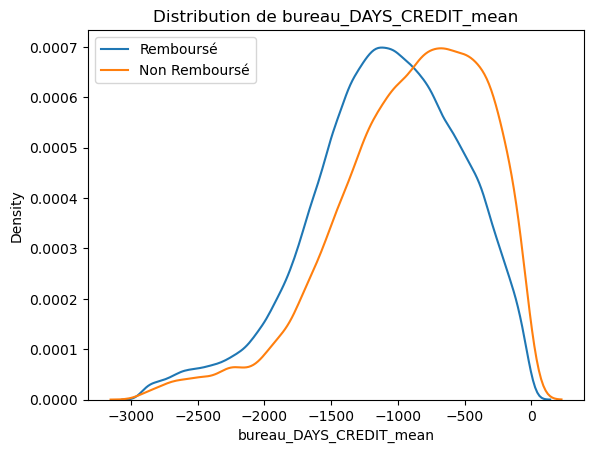

In [67]:
kde_target(var_name = "bureau_DAYS_CREDIT_mean", df = app_train_with_bureau)

Cette variable représente la "moyenne d'ancienneté" des crédits précédemment contractés.

Il semblerait que, plus cette moyenne est faible (et donc plus les crédits ancennement contractés sont récents), plus la probabilité de faire défaut est importante (encore une fois, cela reste une très légère tendance).

Le coefficient de corrélation entre la target et cette variable est 0.08903758347314678
Valeur médiane pour les prêts remboursés : -33.667
Valeur médiane pour les prêts non remboursés -27.0


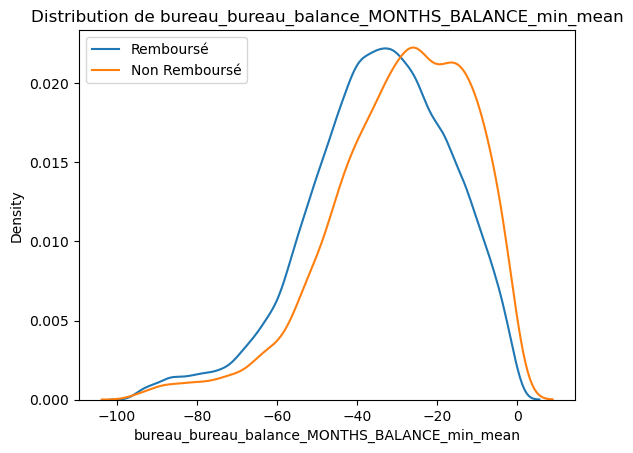

In [68]:
kde_target(var_name = "bureau_bureau_balance_MONTHS_BALANCE_min_mean", df = app_train_with_bureau)

Si je l'interprète correctement, cette variable est calculée comme ceci :
1. On compte la durée (en mois) des prêts dans l'historique du client
2. On en fait la moyenne

Encore une fois, la tendance est vraiment très légère, mais si on veut dire quelque chose, il semblerait que plus les clients ont l'habitude des prêts qui s'étalent plus longuement, plus ils ont tendance à rembourser dans les temps.


Encore une fois, que ce soit l'une ou l'autre variables observées, il est toujours aussi difficile d'en tirer grand chose, à cause des corrélations extrêmement faibles.

## 4.2 Les autres dataframes

Cela concerne previous_applications, qui possède ensuite un lien via "SK_ID_PREV" avec POS_CASH_balance, credit_card_balance, ainsi que instalments_payments.

### 4.2.1 Rapide tour d'horizon

Regardons brièvement comment s'organisent ces dataframes, avant de réutiliser les fonctions ci-dessus pour effectuer une fusion rapide.

In [69]:
previous_applications = pd.read_csv('../Données/previous_application.csv')
POS_CASH = pd.read_csv('../Données/POS_CASH_balance.csv')
installments = pd.read_csv('../Données/installments_payments.csv')
credit_card = pd.read_csv('../Données/credit_card_balance.csv')

In [70]:
previous_applications.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


Celui-ci contient de nombreuses features, dont des catégorielles, des numériques, et deux identifiants (SK_ID_CURR, SK_ID_PREV)

In [71]:
POS_CASH.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


Peu de features, et pas de chance, l'une d'elles est catégorielle. On le fusionnera sur previous_applications, il faudra penser à retirer SK_ID_CURR au préalable.

In [72]:
installments.head()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585


Petit coup de chance, ici, on n'aura pas à s'inquiéter des variables catégorielles. Cela nous simplifiera légèrement la tâche.

In [73]:
credit_card.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,...,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,...,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,...,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,...,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,...,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0


Et pour celui-ci, on procédera de la même manière que pour POS_CASH.

### 4.2.2 Fusion effective

On réécrit une fonction, comme pour bureau et bureau_balance. La fonction possède exactement la même structure, mais elle s'applique à 4 dataframes et non 2.

In [74]:
def merge_previous_applications (df):
    """
    Just a practical function to merge 'installments', 'POS_CASH', 'credit_card', and 'previous_application' to 'df'
    
    Parameters
    ------
    df (dataframe):
        the df to merge on
        
    Return
    ------
    df_merged (dataframe):
        the same dataframe, with all the features from 'installments', 'POS_CASH', 'credit_card', and 'previous_application' added
    """
    # We import the dataframes (just in case i reuse this somewhere else)
    previous_applications = pd.read_csv('../Données/previous_application.csv')
    POS_CASH = pd.read_csv('../Données/POS_CASH_balance.csv')
    installments = pd.read_csv('../Données/installments_payments.csv')
    credit_card = pd.read_csv('../Données/credit_card_balance.csv')
    
    # We will first merge everyone on previous_applications via SK_ID_PREV
    # Starting with POS_CASH
    POS_CASH.drop(columns = ["SK_ID_CURR"], inplace = True)
    POS_CASH_num = agg_numeric_features(POS_CASH, 'SK_ID_PREV', 'pos_cash')
    POS_CASH_cat = count_categorical(POS_CASH, 'SK_ID_PREV', 'pos_cash')
    
    # We merge both of them
    new_POS_CASH = POS_CASH_num.merge(POS_CASH_cat, on = "SK_ID_PREV")
    
    # We merge all of this with 'previous_applications'
    previous_applications_merged = previous_applications.merge(new_POS_CASH, how = 'left', on = 'SK_ID_PREV')
    
    # We do all of this again with the credit_card dataframe
    credit_card.drop(columns = ["SK_ID_CURR"], inplace = True)
    credit_card_num = agg_numeric_features(credit_card, 'SK_ID_PREV', 'credit_card')
    credit_card_cat = count_categorical(credit_card, 'SK_ID_PREV', 'credit_card')
    new_credit_card = credit_card_num.merge(credit_card_cat, on = "SK_ID_PREV")
    previous_applications_merged = previous_applications_merged.merge(new_credit_card, how = 'left', on = 'SK_ID_PREV')
    
    # Now we have an easier time with installments because no categorical features
    installments.drop(columns = ["SK_ID_CURR"], inplace = True)
    new_installments = agg_numeric_features(installments, 'SK_ID_PREV', 'installments')
    previous_applications_merged = previous_applications_merged.merge(new_installments, how = 'left', on = 'SK_ID_PREV')
    
    
    # We only need to proceed with previous_applications now, same way as "bureau" in the last function
    previous_applications_merged.drop(columns = ["SK_ID_PREV"], inplace = True)
    
    prev_apps_num = agg_numeric_features(previous_applications_merged, 'SK_ID_CURR', 'previous_application')
    prev_apps_cat = count_categorical(previous_applications_merged, 'SK_ID_CURR', 'previous_application')
    new_prev_apps = prev_apps_num.merge(prev_apps_cat, on = 'SK_ID_CURR')
    
    # Finally we can merge it all with 'df'
    merged_with_previous_apps = df.merge(new_prev_apps, how = 'left', on = 'SK_ID_CURR')
    
    return merged_with_previous_apps

In [75]:
app_train_complete = merge_previous_applications(app_train_with_bureau)

In [76]:
print("Avec tous les dataframes réunis, on obtient", app_train_complete.shape[1], "features au total")

Avec tous les dataframes réunis, on obtient 1649 features au total


C'est beaucoup ! On essaiera de réduire un peu ce nombre à l'avenir.

In [77]:
app_train_complete.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,previous_application_PRODUCT_COMBINATION_POS industry without interest_count,previous_application_PRODUCT_COMBINATION_POS industry without interest_freq,previous_application_PRODUCT_COMBINATION_POS mobile with interest_count,previous_application_PRODUCT_COMBINATION_POS mobile with interest_freq,previous_application_PRODUCT_COMBINATION_POS mobile without interest_count,previous_application_PRODUCT_COMBINATION_POS mobile without interest_freq,previous_application_PRODUCT_COMBINATION_POS other with interest_count,previous_application_PRODUCT_COMBINATION_POS other with interest_freq,previous_application_PRODUCT_COMBINATION_POS others without interest_count,previous_application_PRODUCT_COMBINATION_POS others without interest_freq
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0.0,0.0,0.0,0.000000,0.0,0.0,1.0,1.0,0.0,0.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0.0,0.0,0.0,0.000000,1.0,1.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0.0,0.0,1.0,0.166667,0.0,0.0,0.0,0.0,0.0,0.0


## 4.3 Retour sur les features métier

Avant de passer à la suite, il me reste quelques features à ajouter. En effet, j'en avais parlé en 4.0 et j'avais fait une liste. Sur cette liste, certaines features ont déjà été créées, les autres doivent l'être maintenant.

Celles qui sont déjà créées :

- Le nombre de prêts précédemment contractés
- La date du dernier prêt contracté 
- Le client a-t-il déjà un prêt en cours ? (Oui/Non) 
- Le client a-t-il déjà été en défaut de paiement auparavant ? (Oui/Non)

Celle qui restent à créer :

- La durée du crédit (en mois ou en années)
- Le ratio "Revenu du client" / "Mensualités du prêt"
- (Facultatif) Le client a-t-il 3x le montant des mensualités en revenus (Oui/Non)
- Le ratio "Jours travaillés"/"Jours vécus", en partant des 18 ans
- Le taux d'intérêt global

Commençons par la durée du crédit.
On connaît le montant total du crédit, et on connaît les "Annuity". Il suffit d'une division.


In [78]:
app_train_complete["CREDIT_TERM"] = app_train_complete["AMT_CREDIT"] / app_train_complete["AMT_ANNUITY"]
app_train_complete["CREDIT_TERM"].describe()

C:\Users\Yann\AppData\Local\Temp\ipykernel_8148\412395427.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  app_train_complete["CREDIT_TERM"] = app_train_complete["AMT_CREDIT"] / app_train_complete["AMT_ANNUITY"]


count    307499.000000
mean         21.612322
std           7.823823
min           8.036674
25%          15.614496
50%          20.000000
75%          27.099985
max          45.305079
Name: CREDIT_TERM, dtype: float64

Le kernel Kaggle que je suivais disait que ceci se compte en mois, je pense plutôt que ce sont des années, au vu de la fourchette observée, et aussi des valeurs de "AMT_ANNUITY" qui seraient trop élevées pour du mensuel.

Ensuite, on a le ratio revenu / annuités. Très simple à calculer

In [79]:
app_train_complete['ANNUITY_INCOME_PERCENT'] = app_train_complete['AMT_ANNUITY'] / app_train_complete['AMT_INCOME_TOTAL']
app_train_complete['ANNUITY_INCOME_PERCENT'].describe()

C:\Users\Yann\AppData\Local\Temp\ipykernel_8148\935978868.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  app_train_complete['ANNUITY_INCOME_PERCENT'] = app_train_complete['AMT_ANNUITY'] / app_train_complete['AMT_INCOME_TOTAL']


count    307499.000000
mean          0.180930
std           0.094574
min           0.000224
25%           0.114782
50%           0.162833
75%           0.229067
max           1.875965
Name: ANNUITY_INCOME_PERCENT, dtype: float64

Je m'étonne que cela aille au-delà de 1. Observons.

In [80]:
app_train_complete.loc[app_train_complete['ANNUITY_INCOME_PERCENT'] >= 1,:]

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,previous_application_PRODUCT_COMBINATION_POS mobile with interest_count,previous_application_PRODUCT_COMBINATION_POS mobile with interest_freq,previous_application_PRODUCT_COMBINATION_POS mobile without interest_count,previous_application_PRODUCT_COMBINATION_POS mobile without interest_freq,previous_application_PRODUCT_COMBINATION_POS other with interest_count,previous_application_PRODUCT_COMBINATION_POS other with interest_freq,previous_application_PRODUCT_COMBINATION_POS others without interest_count,previous_application_PRODUCT_COMBINATION_POS others without interest_freq,CREDIT_TERM,ANNUITY_INCOME_PERCENT
678,100784,1,Cash loans,F,N,Y,0,54000.0,1885500.0,74191.5,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,25.413963,1.373917
20727,124157,1,Cash loans,F,Y,Y,0,25650.0,2173500.0,48118.5,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,45.169737,1.875965
25802,129999,0,Cash loans,F,N,Y,0,46044.0,1024740.0,52452.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,19.536719,1.139171
35791,141454,0,Cash loans,F,Y,Y,0,45000.0,2215224.0,58567.5,...,1.0,0.142857,0.0,0.000000,0.0,0.0,0.0,0.0,37.823434,1.301500
49185,156942,0,Cash loans,F,Y,Y,0,33750.0,835380.0,36927.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,22.622471,1.094133
58379,167672,0,Cash loans,F,Y,N,0,54000.0,1724688.0,60079.5,...,1.0,0.500000,0.0,0.000000,0.0,0.0,0.0,0.0,28.706764,1.112583
64338,174612,0,Cash loans,F,N,Y,0,54000.0,1574532.0,64260.0,...,1.0,0.333333,0.0,0.000000,0.0,0.0,0.0,0.0,24.502521,1.190000
68803,179800,0,Cash loans,F,N,Y,0,31500.0,755190.0,32125.5,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,23.507494,1.019857
95599,210988,0,Cash loans,M,Y,Y,0,76500.0,2013840.0,82152.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,24.513585,1.073882
112431,230424,0,Cash loans,F,N,Y,0,40500.0,472500.0,44635.5,...,1.0,1.000000,0.0,0.000000,0.0,0.0,0.0,0.0,10.585745,1.102111


Apparemment certains clients ont même pu rembourser alors qu'ils touchent moins que le crédit. Peut-être un garant ?

Toujours est-il qu'à partir de ceci, je peux créer la variable suivante.

In [81]:
app_train_complete['THREE_TIMES_ANNUITY_AS_INCOME'] = (app_train_complete['ANNUITY_INCOME_PERCENT'] <= 1/3).astype(int)
app_train_complete['THREE_TIMES_ANNUITY_AS_INCOME'].describe()

count    307511.000000
mean          0.933391
std           0.249344
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: THREE_TIMES_ANNUITY_AS_INCOME, dtype: float64

On a donc 93.3% des postulants qui ont bien 3 fois les annuités en revenu.

In [82]:
# Maintenant, pour le calcul des intérêts.
app_train_complete['GLOBAL_INTEREST_RATE'] = (app_train_complete['AMT_CREDIT'] / app_train_complete['AMT_GOODS_PRICE'] - 1) * 100
app_train_complete['GLOBAL_INTEREST_RATE'].describe()

count    307233.000000
mean         12.299517
std          12.404500
min         -85.000000
25%           0.000000
50%          11.880000
75%          19.800000
max         500.000000
Name: GLOBAL_INTEREST_RATE, dtype: float64

On dirait qu'on a des outliers (négatifs et positifs)
Observons !

In [83]:
app_train_complete.loc[app_train_complete['GLOBAL_INTEREST_RATE'] < 0, :]

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,previous_application_PRODUCT_COMBINATION_POS mobile without interest_count,previous_application_PRODUCT_COMBINATION_POS mobile without interest_freq,previous_application_PRODUCT_COMBINATION_POS other with interest_count,previous_application_PRODUCT_COMBINATION_POS other with interest_freq,previous_application_PRODUCT_COMBINATION_POS others without interest_count,previous_application_PRODUCT_COMBINATION_POS others without interest_freq,CREDIT_TERM,ANNUITY_INCOME_PERCENT,THREE_TIMES_ANNUITY_AS_INCOME,GLOBAL_INTEREST_RATE
1942,102276,0,Revolving loans,M,Y,Y,0,540000.0,315000.0,15750.0,...,NaN,NaN,NaN,NaN,NaN,NaN,20.0,0.029167,1,-30.000000
2138,102512,0,Revolving loans,M,Y,Y,0,112500.0,135000.0,6750.0,...,0.0,0.000000,0.0,0.00,0.0,0.0,20.0,0.060000,1,-33.333333
2808,103276,0,Revolving loans,M,N,Y,0,189000.0,337500.0,16875.0,...,0.0,0.000000,0.0,0.00,0.0,0.0,20.0,0.089286,1,-37.500000
3769,104401,0,Revolving loans,M,Y,Y,0,112500.0,135000.0,6750.0,...,0.0,0.000000,0.0,0.00,0.0,0.0,20.0,0.060000,1,-64.705882
4179,104889,0,Revolving loans,M,Y,Y,1,436500.0,450000.0,22500.0,...,1.0,0.166667,0.0,0.00,0.0,0.0,20.0,0.051546,1,-50.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300919,448622,0,Revolving loans,F,N,Y,0,108000.0,157500.0,7875.0,...,0.0,0.000000,0.0,0.00,0.0,0.0,20.0,0.072917,1,-12.500000
300971,448680,0,Revolving loans,F,Y,Y,3,292500.0,675000.0,33750.0,...,0.0,0.000000,0.0,0.00,0.0,0.0,20.0,0.115385,1,-21.052632
303227,451314,0,Revolving loans,F,Y,N,2,225000.0,225000.0,11250.0,...,0.0,0.000000,1.0,0.25,0.0,0.0,20.0,0.050000,1,-44.444444
303870,452064,0,Revolving loans,M,Y,Y,0,180000.0,225000.0,11250.0,...,1.0,0.076923,0.0,0.00,0.0,0.0,20.0,0.062500,1,-28.571429


In [84]:
# à explorer

In [85]:
app_train_complete.loc[app_train_complete['GLOBAL_INTEREST_RATE'] > 100, :]

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,previous_application_PRODUCT_COMBINATION_POS mobile without interest_count,previous_application_PRODUCT_COMBINATION_POS mobile without interest_freq,previous_application_PRODUCT_COMBINATION_POS other with interest_count,previous_application_PRODUCT_COMBINATION_POS other with interest_freq,previous_application_PRODUCT_COMBINATION_POS others without interest_count,previous_application_PRODUCT_COMBINATION_POS others without interest_freq,CREDIT_TERM,ANNUITY_INCOME_PERCENT,THREE_TIMES_ANNUITY_AS_INCOME,GLOBAL_INTEREST_RATE
12139,114154,0,Revolving loans,F,N,Y,0,168750.0,315000.0,15750.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,20.0,0.093333,1,250.000000
34516,139994,0,Revolving loans,F,N,Y,1,67500.0,180000.0,9000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,20.0,0.133333,1,166.666667
40074,146420,0,Revolving loans,M,Y,Y,1,112500.0,270000.0,13500.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,20.0,0.120000,1,200.000000
40302,146687,0,Revolving loans,F,N,Y,0,202500.0,270000.0,13500.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,20.0,0.066667,1,500.000000
42864,149626,0,Revolving loans,F,N,N,0,225000.0,337500.0,16875.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,20.0,0.075000,1,200.000000
75080,187078,0,Revolving loans,M,Y,Y,1,225000.0,630000.0,31500.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,20.0,0.140000,1,366.666667
91613,206387,0,Revolving loans,F,Y,Y,1,126000.0,202500.0,10125.0,...,0.0,0.0,1.0,0.058824,0.0,0.0,20.0,0.080357,1,125.000000
93640,208738,0,Revolving loans,F,N,N,3,225000.0,225000.0,11250.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,20.0,0.050000,1,150.000000
114589,232879,0,Revolving loans,F,N,Y,0,135000.0,337500.0,16875.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,20.0,0.125000,1,200.000000
136025,257776,0,Revolving loans,F,Y,Y,0,180000.0,540000.0,27000.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,20.0,0.150000,1,166.666667


In [86]:
# à explorer

100% des outliers concernent des "revolving loans". Je ne sais pas exactement si cela est explicable ou non, mais surtout, ces outliers sont relativement peu nombreux, et je pense que cette variable est tout de même utilisable.

Je vais également calculer le taux d'intérêt annuel.

In [87]:
# Désolé, grosse formule, j'admets que j'aurais pu décomposer
app_train_complete["ANNUAL_INTEREST_RATE"] = (((1 + app_train_complete["GLOBAL_INTEREST_RATE"]/100) ** (1 / app_train_complete["CREDIT_TERM"])) - 1) * 100
app_train_complete["ANNUAL_INTEREST_RATE"].describe()

count    307227.000000
mean          0.563916
std           0.552914
min          -9.049611
25%           0.000000
50%           0.529560
75%           0.921547
max           9.372355
Name: ANNUAL_INTEREST_RATE, dtype: float64

Et avec ceci, on a créé toutes les variables que je souhaitais.

Je vais tout de même faire intervenir encore deux fonctions :
- La première me permet d'ajouter toutes les variables que je viens de créer (pour app_test notamment)
- La deuxième encode les variables catégorielles, car en l'état actuel des choses, celles de 'app_train' n'ont pas été encodées.

In [88]:
def add_knowledge_features(df):
    """
    Adds some features to our dataframe (interest rates (global and annual), annuity/income rate, credit length)
    
    Parameters
    ------
    df (dataframe) :
        the df you want the features to be added on 
    
    Return
    ------
    The same dataframe, with 5 more features (as I wrote above)
    """
    # credit term
    df["CREDIT_TERM"] = df["AMT_CREDIT"] / df["AMT_ANNUITY"]
    
    # annuity/income rate
    df['ANNUITY_INCOME_PERCENT'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['THREE_TIMES_ANNUITY_AS_INCOME'] = (df['ANNUITY_INCOME_PERCENT'] <= 1/3).astype(int)
    
    # interest rate (percentage)
    df['GLOBAL_INTEREST_RATE'] = (df['AMT_CREDIT'] / df['AMT_GOODS_PRICE'] - 1) * 100
    df["ANNUAL_INTEREST_RATE"] = (((1 + df["GLOBAL_INTEREST_RATE"]/100) ** (1 / df["CREDIT_TERM"])) - 1) * 100
    
    return df

In [89]:
def encode_all_categorical(df):
    """
    Encodes categorical features, using a LabelEncoder for features with 2 categories, and get_dummies for 3 or more categories
    
    Return
    ------
    the same df, with enconding done.
    """
    le = LabelEncoder()
    le_count = 0

    # Je parcours mes colonnes et je teste si 1. elles sont de type object et 2. elles ont 2 catégories
    for col in df:
        if df[col].dtype == "object":
            if len(list(df[col].unique())) <= 2:
                # Dans ce cas, j'utilise le LabelEncoder
                df[col] = le.fit_transform(df[col])
            
                le_count += 1

    print(le_count, "colonnes encodées avec LabelEncoder")
    
    # On encode les autres variables catégorielles avec un One-Hot Encoder
    df = pd.get_dummies(df)

    return df

In [90]:
app_train_complete = encode_all_categorical(app_train_complete)
app_train_complete.shape

3 colonnes encodées avec LabelEncoder


(307511, 1775)

On a dorénavant 1775 features.
On a presque terminé !

## 4.4 Alignement avec le jeu de test

Opérons toutes ces transformations sur app_test maintenant.

In [91]:
app_test = pd.read_csv('../Données/application_test.csv')

In [92]:
app_test = merge_bureaus(app_test)
app_test_merged = merge_previous_applications(app_test)
app_test_merged = add_knowledge_features(app_test_merged)
app_test_complete = encode_all_categorical(app_test_merged)
app_test_complete.shape

C:\Users\Yann\AppData\Local\Temp\ipykernel_8148\3759859441.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["CREDIT_TERM"] = df["AMT_CREDIT"] / df["AMT_ANNUITY"]
C:\Users\Yann\AppData\Local\Temp\ipykernel_8148\3759859441.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['ANNUITY_INCOME_PERCENT'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
C:\Users\Yann\AppData\Local\Temp\ipykernel_8148\3759859441.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many ti

4 colonnes encodées avec LabelEncoder


(48744, 1770)

On constate qu'il manque quelques features. En effet, il manque déjà TARGET, et c'est normal. Pour le reste, certaines catégories présentes dans app_train ne l'étaient peut-être pas dans app_test. Il faut donc les aligner.

In [93]:
# Je sauvegarde la target
train_labels = app_train_complete['TARGET']

# J'aligne
app_train_complete, app_test_complete = app_train_complete.align(app_test_complete, join = 'inner', axis = 1)

#Je récupère la target
app_train_complete['TARGET'] = train_labels

In [94]:
app_train_complete.shape

(307511, 1770)

In [95]:
app_test_complete.shape

(48744, 1769)

# 5. Brève sélection des features

Bien ! Maintenant qu'on a bien fait grossir le nombre de features, on va essayer de l'amoindrir un peu.
Pour cela, on va essentiellement regarder deux choses :

- Est-ce que certaines de nos features ont trop de valeurs manquantes ? (Seuil à définir, autour de 80 - 90%)
- Est-ce que certaines features sont trop corrélées ? (Seuil à définir, autour de 0.8 ? 0.6 ?)

## 5.1 Valeurs manquantes

In [96]:
# On a déjà la fonction qu'il nous faut

missing_values_table(app_train_complete)

This dataframe has 1770 columns. 
There are 1592 columns with missing values.


,Missing Values,% of Total Values
previous_application_RATE_INTEREST_PRIMARY_max,302902,98.5
previous_application_RATE_INTEREST_PRIMARY_mean,302902,98.5
previous_application_RATE_INTEREST_PRIMARY_min,302902,98.5
previous_application_RATE_INTEREST_PRIVILEGED_mean,302902,98.5
previous_application_RATE_INTEREST_PRIVILEGED_max,302902,98.5
...,...,...
NAME_INCOME_TYPE_Unemployed,0,0.0
NAME_INCOME_TYPE_Working,0,0.0
NAME_EDUCATION_TYPE_Academic degree,0,0.0
NAME_EDUCATION_TYPE_Higher education,0,0.0


In [97]:
# Admettons qu'on fixe un seuil à 80% de valeurs manquantes
train_missing = (app_train_complete.isnull().sum() / len(app_train_complete)).sort_values(ascending = False)
train_missing = list(train_missing.index[train_missing > 0.8])

print("On a", len(train_missing), "features présentant plus de 80% de valeurs manquantes")

On a 69 features présentant plus de 80% de valeurs manquantes


In [98]:
# On les supprime.
train = app_train_complete.drop(columns = train_missing)
train.shape

(307511, 1701)

## 5.2 Variables trop corrélées

Testons les corrélations entre nos variables, et éliminons celles qui sont trop fortes.

Avant cela, je regarde les corrélations avec ma target, parce que je ne l'ai pas encore fait depuis l'agrégation de tous les dataframes (+ la connaissance métier), et je veux aussi m'épargner l'écart puis le retour de la variable 'TARGET' dans la suite.

In [99]:
# Je le passe en commentaire au cas où je doive relancer ce notebook, car cela prend 30 minutes
# most_correlated_features(train, 30)

TARGET                                                                 1.000000
EXT_SOURCE_3                                                           0.178919
EXT_SOURCE_2                                                           0.160472
EXT_SOURCE_1                                                           0.155317
previous_application_credit_card_CNT_DRAWINGS_CURRENT_max_max          0.101090
previous_application_credit_card_CNT_DRAWINGS_CURRENT_max_mean         0.100961
previous_application_credit_card_CNT_DRAWINGS_CURRENT_max_min          0.100664
bureau_DAYS_CREDIT_mean                                                0.089729
bureau_bureau_balance_MONTHS_BALANCE_min_mean                          0.089038
previous_application_credit_card_AMT_BALANCE_mean_max                  0.086862
previous_application_credit_card_AMT_BALANCE_mean_mean                 0.086693
previous_application_credit_card_AMT_BALANCE_mean_min                  0.086455
previous_application_credit_card_AMT_TOT

On a pas mal de nouvelles features intéresantes, mais les corrélations sont toujours très faibles. Poursuivons donc en supprimant les variables trop corrélées.

In [100]:
# Matrice de corrélation triangulaire
corr_matrix = train.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
upper.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,TARGET
SK_ID_CURR,NaN,0.001654,0.001216,0.000703,0.001129,0.001820,0.000343,0.000433,0.000232,0.000849,...,0.002073,0.000976,0.000072,0.001396,0.002300,0.001281,0.000270,0.000510,0.002549,0.002108
NAME_CONTRACT_TYPE,NaN,NaN,0.004022,0.067177,0.029998,0.003531,0.221648,0.241544,0.185850,0.026867,...,0.006874,0.003783,0.010609,0.001571,0.011120,0.015098,0.000040,0.027372,0.000339,0.030896
FLAG_OWN_CAR,NaN,NaN,NaN,0.002817,0.102023,0.083383,0.116225,0.141588,0.120310,0.041314,...,0.005064,0.000727,0.011128,0.002715,0.009758,0.025584,0.009212,0.034754,0.007584,0.021851
FLAG_OWN_REALTY,NaN,NaN,NaN,NaN,0.002366,0.002934,0.039270,0.005225,0.045537,0.015175,...,0.000679,0.002567,0.000833,0.000757,0.014874,0.017445,0.014577,0.022013,0.008535,0.006148
CNT_CHILDREN,NaN,NaN,NaN,NaN,NaN,0.012882,0.002145,0.021374,0.001827,0.025573,...,0.005272,0.000709,0.001607,0.002032,0.020892,0.025088,0.011036,0.038644,0.004525,0.019187


In [104]:
# Seuil défini à ne pas dépasser (à éventuellement modifier après tests de modélisation)
threshold = 0.8

# Choix des colonnes qui dépassent le seuil de corrélation avec au moins une variable précédente
to_drop_8 = [column for column in upper.columns if any(upper[column] > threshold)]

print('Il y a %d colonnes à supprimer.' % (len(to_drop_8)))

Il y a 1036 colonnes à supprimer.


Ok. C'est pas mal du tout, c'est même beaucoup.
Je vais en fait créer 3 versions pour l'instant, avec des seuils à 0.8, 0.85, et 0.9

In [105]:
threshold = 0.85

# Choix des colonnes qui dépassent le seuil de corrélation avec au moins une variable précédente
to_drop_85 = [column for column in upper.columns if any(upper[column] > threshold)]

print('Il y a %d colonnes à supprimer.' % (len(to_drop_85)))

Il y a 940 colonnes à supprimer.


In [106]:
threshold = 0.9

# Choix des colonnes qui dépassent le seuil de corrélation avec au moins une variable précédente
to_drop_9 = [column for column in upper.columns if any(upper[column] > threshold)]

print('Il y a %d colonnes à supprimer.' % (len(to_drop_9)))

Il y a 857 colonnes à supprimer.


In [107]:
train_8 = train.drop(columns = to_drop_8)
train_8.shape

(307511, 665)

In [108]:
train_85 = train.drop(columns = to_drop_85)
train_85.shape

(307511, 761)

In [109]:
train_9 = train.drop(columns = to_drop_9)
train_9.shape

(307511, 844)

On a donc 3 versions de jeux d'entraînement. 
Il faut aussi réaligner notre jeu de test en fonction de cela.

In [110]:
# Pour un seuil de 0.8
train_labels = train_8['TARGET']
train_8, test_8 = train_8.align(app_test_complete, join = 'inner', axis = 1)
train_8['TARGET'] = train_labels

test_8.shape

(48744, 664)

In [111]:
train_8.shape

(307511, 665)

In [112]:
# Cela me va. Je procède de même pour 0.85 et 0.9
train_labels = train_85['TARGET']
train_85, test_85 = train_85.align(app_test_complete, join = 'inner', axis = 1)
train_85['TARGET'] = train_labels

train_labels = train_9['TARGET']
train_9, test_9 = train_9.align(app_test_complete, join = 'inner', axis = 1)
train_9['TARGET'] = train_labels

Il est probable que je n'en utilise qu'une version ou deux sur les 3, mais tant qu'à faire, je préfère ne pas avoir à relancer tout ce notebook lorsque j'aurai besoin de faire ces tests.

# 6. Export des datasets prêts à être utilisés

In [114]:
train_8.to_csv("../Données/train_8.csv", index_label=False)
train_85.to_csv("../Données/train_85.csv", index_label=False)
train_9.to_csv("../Données/train_9.csv", index_label=False)
test_8.to_csv("../Données/test_8.csv", index_label=False)
test_85.to_csv("../Données/test_85.csv", index_label=False)
test_9.to_csv("../Données/test_9.csv", index_label=False)

In [115]:
train_8.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,...,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_Yes,TARGET
0,100002,0,0,1,0,202500.0,406597.5,24700.5,0.018801,-9461,...,0,0,0,0,0,0,1,0,0,1
1,100003,0,0,0,0,270000.0,1293502.5,35698.5,0.003541,-16765,...,0,1,0,0,0,0,0,0,0,0
2,100004,1,1,1,0,67500.0,135000.0,6750.0,0.010032,-19046,...,0,0,0,0,0,0,0,0,0,0
3,100006,0,0,1,0,135000.0,312682.5,29686.5,0.008019,-19005,...,0,0,0,0,0,0,0,0,0,0
4,100007,0,0,1,0,121500.0,513000.0,21865.5,0.028663,-19932,...,0,0,0,0,0,0,0,0,0,0
